In [1]:
import time
import copy

import numpy as np
import pandas as pd

import tensorflow as tf

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import models, datasets, transforms

import matplotlib.pyplot as plt
from PIL import Image



if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {DEVICE} for inference')

Using cuda for inference


##### Model Settings #######

In [2]:
LEARNING_RATE = 0.001

BATCH_SIZE = 128
NUM_EPOCHS = 10

NUM_INPUTS = 1*28*28 # grayscale (1-channel) 28*28 picture
NUM_CLASSES = 10 # digits 0 to 9

##### Load MNIST Dataset #######

In [3]:
train_data = datasets.MNIST(
    root="dataset",
    train=True,
    download=True,
    transform= transforms.ToTensor()
)

test_data = datasets.MNIST(
    root="dataset",
    train=False,
    download=True,
    transform= transforms.ToTensor()
)

train_loader = DataLoader(dataset=train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_data, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

CLASSES = train_data.classes

In [4]:
resnet18 = models.resnet18(pretrained=True)

print(resnet18.conv1)
print(resnet18.fc)

# we only need 10 classes need to cahnge ouput layer
# we also need to chnage so it takes 1 cahnnel instead of three channels
resnet18.fc = nn.Linear(resnet18.fc.in_features,NUM_CLASSES)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
print()
print(resnet18.conv1)
print(resnet18.fc)

# Make sure to send our model to GPU if available
resnet18 = resnet18.to(DEVICE)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Linear(in_features=512, out_features=1000, bias=True)

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Linear(in_features=512, out_features=10, bias=True)


c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Compare True Label w/ Predicted Label #####

In [5]:
def compute_accuracy (model, data_loader, device):
    model = model.to(device)
    model = model.eval() # put the model to evaultion mode
    
    num_correct_prediction = 0
    num_total_labels = 0
    
    with torch.no_grad():
        
        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            probabilities = resnet18(inputs.to(DEVICE))
            predicted_class = torch.argmax(probabilities, dim=1) # Class predicted by model
            
            num_total_labels += labels.size()[0]
            num_correct_prediction += (predicted_class == labels).sum()

    return num_correct_prediction/num_total_labels * 100

#### Test w/o training ####

Predicted Num : 4
Actual Num : 4

Total Accuracy on test data : 13.180 %


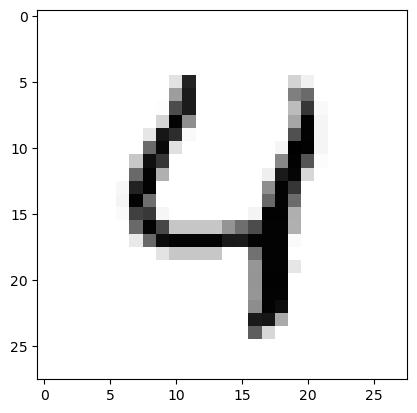

In [6]:
for batch_index, (inputs, labels) in enumerate(test_loader):

    inputs = inputs
    labels = labels
    break
    

    
img = np.transpose(inputs[4], axes=(1, 2, 0))
img = np.squeeze(img.numpy(), axis=2)
plt.imshow(img, cmap='Greys')
plt.show



resnet18 = resnet18.eval()

with torch.no_grad(): # Save Performance when evaluting or prediciting
    probabilities = resnet18(inputs.to(DEVICE))
    predicted_class = torch.argmax(probabilities, dim=1)

print("Predicted Num : {:d}".format(predicted_class[4]))
print("Actual Num : {:d}".format(labels[4]))
print("\nTotal Accuracy on test data : {:.3f} %".format(compute_accuracy(resnet18,test_loader,DEVICE)))

#### Train Model ####

In [7]:
def train_model (model, data_loader, learning_rate, num_epochs, device):
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    best_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0
    
    start_time = time.time()
    
    for epochs in range(num_epochs):
        
        print("EPOCH : {0}/{1}".format(epochs+1,num_epochs))
        print("-"*30)
        
        # train first
        model.train()
        for batch_index, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)   
             
            probabilities = resnet18(inputs)
            predicted_class = torch.argmax(probabilities, dim=1)
            
            optimizer.zero_grad()
            loss = nn.functional.cross_entropy(probabilities,labels)
                
            loss.backward()
            optimizer.step()
            #scheduler.step()
            
            if (batch_index % 50 == 0) :
                print("BATCH : {:3d}/{:3d} | LOSS : {:.3f} ".format(batch_index,len(data_loader),loss))
            
        
        # evalute
        model.eval()
        with torch.set_grad_enabled(False):
            accuracy = compute_accuracy(model,data_loader,DEVICE)
            print("\nTotal Accuracy On Training Data : {:.3f} %".format(accuracy))
        
        # Save best weights
        if (accuracy > best_accuracy):
            best_accuracy = accuracy
            best_weights = copy.deepcopy(model.state_dict())
        
        print("Elapsed Time : {:.0f} min {:.0f} sec\n".format((time.time() - start_time)/60 , (time.time() - start_time)%60)) 
    
    print("\nTotal Time : {:.0f} min {:.0f} sec".format((time.time() - start_time)/60 , (time.time() - start_time)%60))
    
    
    model.load_state_dict(best_weights)
    return model

In [8]:
resnet18 = train_model(resnet18,train_loader,LEARNING_RATE,NUM_EPOCHS,DEVICE)

EPOCH : 1/10
------------------------------
BATCH :   0/469 | LOSS : 2.657 
BATCH :  50/469 | LOSS : 1.941 
BATCH : 100/469 | LOSS : 1.517 
BATCH : 150/469 | LOSS : 1.221 
BATCH : 200/469 | LOSS : 1.039 
BATCH : 250/469 | LOSS : 0.921 
BATCH : 300/469 | LOSS : 0.570 
BATCH : 350/469 | LOSS : 0.590 
BATCH : 400/469 | LOSS : 0.471 
BATCH : 450/469 | LOSS : 0.544 

Total Accuracy On Training Data : 88.393 %
Elapsed Time : 0 min 21 sec

EPOCH : 2/10
------------------------------
BATCH :   0/469 | LOSS : 0.496 
BATCH :  50/469 | LOSS : 0.370 
BATCH : 100/469 | LOSS : 0.302 
BATCH : 150/469 | LOSS : 0.273 
BATCH : 200/469 | LOSS : 0.320 
BATCH : 250/469 | LOSS : 0.312 
BATCH : 300/469 | LOSS : 0.241 
BATCH : 350/469 | LOSS : 0.283 
BATCH : 400/469 | LOSS : 0.230 
BATCH : 450/469 | LOSS : 0.273 

Total Accuracy On Training Data : 93.930 %
Elapsed Time : 1 min 40 sec

EPOCH : 3/10
------------------------------
BATCH :   0/469 | LOSS : 0.182 
BATCH :  50/469 | LOSS : 0.301 
BATCH : 100/469 | 

### Test w/ Training ###

Predicted Num : 7
Actual Num : 7

Total Accuracy on test data : 97.380 %


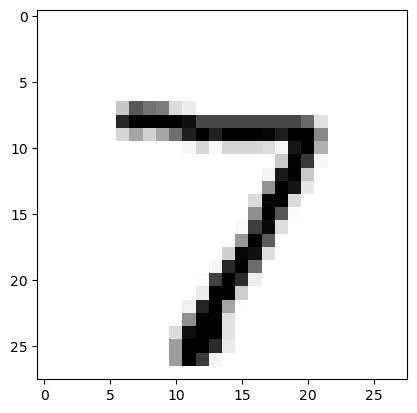

In [9]:
%matplotlib inline

features = torch.empty(0)
true_label = torch.empty(0)

for batch_index, (inputs, labels) in enumerate(test_loader):

    features = torch.cat((features,inputs))
    true_label = torch.cat((true_label,labels))
    
img = np.transpose(features[0], axes=(1, 2, 0))
img = np.squeeze(img.numpy(), axis=2)
plt.imshow(img, cmap='Greys')
plt.show


resnet18 = resnet18.eval()

with torch.no_grad():
    probabilities = resnet18(features.to(DEVICE))
    predicted_class = torch.argmax(probabilities, dim=1)

print("Predicted Num : {:.0f}".format(predicted_class[0]))
print("Actual Num : {:.0f}".format(true_label[0]))

print("\nTotal Accuracy on test data : {:.3f} %".format(compute_accuracy(resnet18,test_loader,DEVICE)))

### Results ###

In [18]:

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support

LABELS = [0,1,2,3,4,5,6,7,8,9]

true_label = true_label.to('cpu')
predicted_label = predicted_class.to('cpu')

cf_matrix = confusion_matrix(true_label,predicted_label)

df = pd.DataFrame(cf_matrix, index = CLASSES, columns = CLASSES)

num_correct = [cf_matrix[i][i] for i in range(len(cf_matrix[0]))]

print("\nConfusion Matrix :-")
print(df.to_markdown())

matrix = precision_recall_fscore_support(true_label,predicted_label,labels=LABELS)
total_label = matrix[:][len(matrix)-1]
accuracy = num_correct / total_label * 100
df_matrix = pd.DataFrame(np.array(matrix).T[:,:-1]*100, index = CLASSES, columns = ["Precison","Recall","F-score"])
df_matrix["Accuracy"] = accuracy
df_matrix.loc["Average"] = df_matrix.mean(axis=0) 


print("\nPerformance Matrix:-")
print(df_matrix.to_markdown())


Confusion Matrix :-
|           |   0 - zero |   1 - one |   2 - two |   3 - three |   4 - four |   5 - five |   6 - six |   7 - seven |   8 - eight |   9 - nine |
|:----------|-----------:|----------:|----------:|------------:|-----------:|-----------:|----------:|------------:|------------:|-----------:|
| 0 - zero  |        961 |         0 |         4 |           1 |          2 |          3 |         4 |           0 |           5 |          0 |
| 1 - one   |          0 |      1125 |         3 |           1 |          0 |          0 |         2 |           1 |           3 |          0 |
| 2 - two   |          3 |         0 |      1001 |          13 |          1 |          0 |         2 |           3 |           9 |          0 |
| 3 - three |          0 |         0 |         5 |         979 |          0 |          9 |         0 |           8 |           7 |          2 |
| 4 - four  |          0 |         2 |         0 |           0 |        957 |          0 |         7 |           1 

In [48]:
TP = np.array([cf_matrix[i][i] for i in range(len(cf_matrix[0]))])

F = np.array([sum(cf_matrix[:,i]) for i in range(len(cf_matrix[0]))])
FP = F - TP

T = np.array([sum(cf_matrix[i,:]) for i in range(len(cf_matrix[0]))])
FN = T - TP

TN = np.array([sum(sum(cf_matrix)) for i in range(len(cf_matrix[0]))]) - TP - FP - FN


precision = TP / (FP+TP)
recall = TP / (FN+TP)
f_score = 2 * (precision*recall)/(precision+recall)
accuracy = TP / T

matrix  = [precision,recall,f_score,accuracy]

df_matrix = pd.DataFrame(np.array(matrix).T*100, index = CLASSES, columns = ["Precison","Recall","F-score","Accuracy"])
df_matrix.loc["Average"] = df_matrix.mean(axis=0) 


print("\nPerformance Matrix:-")
print(df_matrix.to_markdown())


Performance Matrix:-
|           |   Precison |   Recall |   F-score |   Accuracy |
|:----------|-----------:|---------:|----------:|-----------:|
| 0 - zero  |    98.3623 |  98.0612 |   98.2115 |    98.0612 |
| 1 - one   |    99.2063 |  99.1189 |   99.1626 |    99.1189 |
| 2 - two   |    96.5284 |  96.9961 |   96.7617 |    96.9961 |
| 3 - three |    96.9307 |  96.9307 |   96.9307 |    96.9307 |
| 4 - four  |    97.9529 |  97.4542 |   97.7029 |    97.4542 |
| 5 - five  |    96.4365 |  97.0852 |   96.7598 |    97.0852 |
| 6 - six   |    98.0105 |  97.7035 |   97.8568 |    97.7035 |
| 7 - seven |    97.6585 |  97.3735 |   97.5158 |    97.3735 |
| 8 - eight |    95.9267 |  96.7146 |   96.319  |    96.7146 |
| 9 - nine  |    96.5174 |  96.1348 |   96.3257 |    96.1348 |
| Average   |    97.353  |  97.3573 |   97.3547 |    97.3573 |
